In [ ]:
import dataiku
from IPython.display import Image
from dataiku import pandasutils as pdu
import pandas as pd
import numpy as np
from h3 import h3
import folium
from folium.plugins import HeatMap
import branca.colormap as bcm
from pylab import *
import warnings
from shapely.geometry import Polygon
import geopandas as gpd

### Notebook Purpose and Introduction

This notebook extends on the work done by Uber in geo-indexing the world https://eng.uber.com/h3/. Their h3 library enables a user to divide geographical areas into hexagons of various sizes. 

The below functions enable you to create a MULTI-SIZE fit of Uber's hexagons, thus accounting for density variations.

There is also a function to map any grid system created on one dataset to another.

Finally there is a function to visualise the hexagons. 

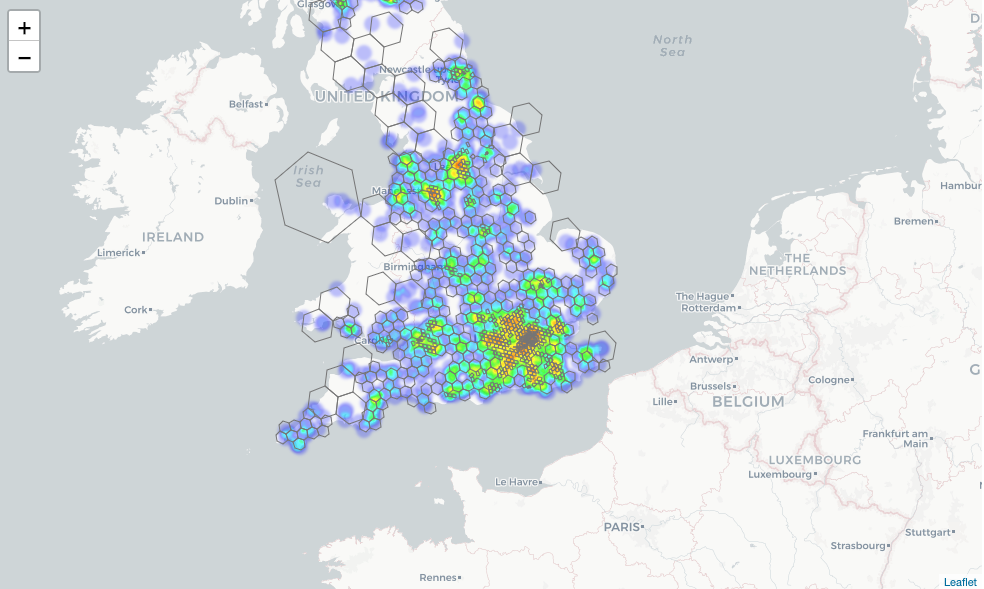

In [3]:
# EXAMPLE OUTPUT 1 - multiple size hexagons overlaid on a density plot for comparison
Image("map1.png")

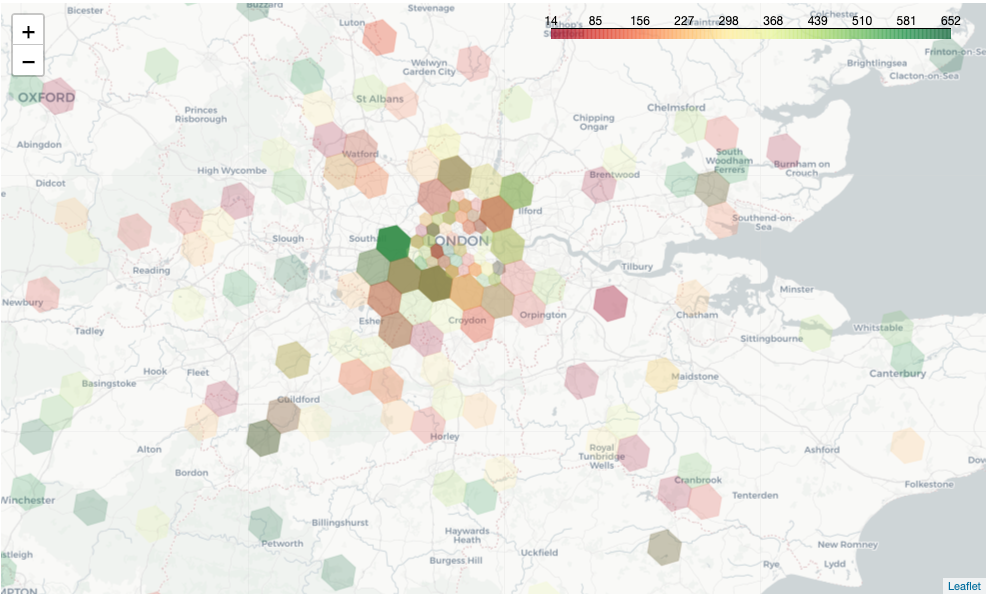

In [2]:
# EXAMPLE OUTPUT 2 - density based hexagons with secondary feature overlaid as colour
Image("map2.png")

In [0]:
def get_hexagons(dataframe, id_col: str, latitude: str, longitude: str, start_res: int, 
                 max_res: int, min_ids_in_ring: int, ring_size = 2, return_wkt= True):
    
    """
    Given a set of id_col with lat/long data, appends a multi-size hexagon grid reference, 
    that best satisifes the input constraints.
    
    Parameters
    ---------- 
        dataframe : pd.DataFrame
            the dataframe to use  
        id_col: string
            the name of the unique identifier column
        latitude / longitude: string
            the names of geographical columns in a passed in dataframe
        start_res : integer
            the smallest possible hexagon grid size (note 11 is the finest possible grid size)
        max_res: integer
            the largest possible hexagon grid size (note 1 is the largest possible grid size)
        min_ids_in_ring : integer
            minimum number of ids in a 'ring of hexagons'
        ring_size : integer
            number of hexagons adjacent to a central hexagon, such that a circle could approximate the collection of hexagons
        return_wkt : boolean
            whether to return a column of geometric polygons of type wkt

    Returns
    --------
    pd.DataFrame
       original dataframe, with two appended columns, h3_idex (hexagon index) and res_for_ids (resolution of hexagon index)
   
    """
    
    # ------------ #
    # 0. DATA PREP #
    # ------------ #
    
    # CHECK INPUTS ARE VALID
    print ("Checking data\n")
    
    if (start_res > 11):
        raise Exception("Starting resolution must be <= 11")
    if (max_res > 11):
        raise Exception ("Max resolution must be <= 11")
    if start_res < max_res:
        raise Exception ("Max resolution cannot be less than starting resolution (i.e. max_resolution = 2, min_resolution = 8)")
    
    # SELECT ONLY GEOSPATIAL DATA
    h3_index_df = dataframe[[id_col, latitude, longitude]]
    
    # REMOVE NULL GEOGRAPHICAL DATA
    if dataframe[[latitude, longitude]].isnull().sum().max() > 0:
        warnings.warn(f"Dataset has {dataframe[[latitude, longitude]].isnull().sum().max()}+ null latitude / longitude values")

    h3_index_df = h3_index_df.dropna(subset=[latitude, longitude])
    
    # ADD HEXAGONS - AT ALL RESOLUTIONS
    print ("Adding all possible hex resolutions\n")
    for i in range(1, 11):
        h3_index_df.loc[:,'h3_idx_{}'.format(i)] = h3_index_df.apply(
            lambda row: h3.geo_to_h3(row[latitude], row[longitude], i),
            axis=1)
        
    # ------------------------------------ #
    # 1. GET THE NUMBER OF idS, PER RING #
    # ------------------------------------ #
    
    # FORCE ALL HEXAGONS TO HAVE RESOLUTION BETWEEN max_res AND start_res 
    counts_per_ring = h3_index_df.copy()
    print ("Fetching selected hexagon indexes\n")

    for i in range(max_res, start_res + 1):
        print (f"Hexagon resolution: {i}")

        # Get the h3_index for hexagon resolution i 
        counts_per_ring['h3_idx_{}'.format(i)] = (counts_per_ring
                                                 .apply(lambda row: h3.geo_to_h3(row[latitude], row[longitude], i), axis=1))

        # Get the count of id per hexagon
        counts_per_hex = (
            h3_index_df['h3_idx_{}'.format(i)]
            .groupby(h3_index_df['h3_idx_{}'.format(i)])
            .count()
        )

        # Reset index of count_per_hex
        counts_per_hex_bis = counts_per_hex.reset_index(name='count_per_hexagon_res_{}'.format(i))

        # Count the number of ids per ring

        # Get the list of hexagons within distance <= ring_size from the central hexagon
        counts_per_hex_bis['list_of_hex_in_ring_of_size_{}'.format(ring_size)] = (
            counts_per_hex_bis
            .apply(lambda x : h3.k_ring(x['h3_idx_{}'.format(i)], ring_size), axis=1)
        )

        # Get the count of ids inside the hexagons in the ring
        counts_per_hex_bis['count_of_elements_in_ring_at_res_{}'.format(i)] = (
            counts_per_hex_bis['list_of_hex_in_ring_of_size_{}'.format(ring_size)]
            .apply(lambda x: counts_per_hex[x].sum())
        )

        counts_per_ring = (
            counts_per_ring
            .merge(counts_per_hex_bis[['h3_idx_{}'.format(i), 'count_of_elements_in_ring_at_res_{}'.format(i)]],  how='left')
        )
        
    # GET THE APPROPRIATE RESOLUTION FOR EACH id LOOKUP
    def f_temp(x):
        i = start_res
        while ( (x['count_of_elements_in_ring_at_res_{}'.format(i)] < min_ids_in_ring)
               and (i > max_res)):
            i -= 1
        return i

    counts_per_ring['res_for_ids'] = (
        counts_per_ring
        .fillna(0)
        .apply(lambda x: f_temp(x), axis=1)
    )

    # GET THE APPROPRIATE h3_idx THAT MATCHES THE RESOLUTION OF HEXAGON REQUIRED FOR THE IDS 
    counts_per_ring['h3_idx'] = counts_per_ring.apply(lambda x: x['h3_idx_{}'.format(int(x['res_for_ids']))], axis=1)

    # FETCH THE NUMBER OF IDS IN THE HEXAGON SURROUNDING A ID, BASED ON IT's GIVEN h3_idx 
    counts_per_ring['count_of_ids_in_ring'] = (
        counts_per_ring
        .apply(lambda x: x['count_of_elements_in_ring_at_res_{}'.format(int(x['res_for_ids']))], axis=1)
    )

    counts_per_ring = counts_per_ring.loc[lambda x: x['h3_idx'] != '0',:]
        
    # COUNT HOW MANY idS ARE IN EACH HEXAGON (at this point there are hexagons overlapping still)
    hexagons = (counts_per_ring.groupby('h3_idx')[id_col]
        .count()
        .reset_index()
        .loc[lambda x: x['h3_idx'] != '0',:]
        .sort_values(by=id_col, ascending=False))
     
    # ------------------------------- #
    # 2. REMOVE HEXAGONS THAT OVERLAP #
    # ------------------------------- #
        
    # FUNCTION TO REMOVE FAMILY TREE TO LEVEL n (REMOVE CHILDREN WHERE OVERLAPPING HEXAGONS)
    def remove_family_tree(hexagons, n):
        # Remove parent hexagons (that overlap their children on the map)
        hexagons['res'] = hexagons['h3_idx'].str[1]
        hexagons['parent'] = hexagons.apply(lambda x: h3.h3_to_parent(x['h3_idx'], int(x['res'])-n), axis=1)

        # Hexagons without parents (not plotted - but available)
        hexagons_deparented = (hexagons[['h3_idx']]
                               .merge(hexagons[['parent']],how='left', left_on='h3_idx', right_on='parent')
                               .loc[lambda x: x['parent']
                               .isna(),'h3_idx'])

        # Remove children, if their parents are present in list of hexagons
        hexagon_child_parent_matched = (hexagons[['h3_idx']]
                                       .merge(hexagons[['parent','h3_idx']],
                                              how='left', left_on='h3_idx', 
                                              right_on='parent'))

        children_to_drop = (hexagon_child_parent_matched
                                .loc[lambda x: x['h3_idx_y'].notnull(),'h3_idx_y']
                                .to_frame())

        # List of hexagons with children removed (if their parents are present)
        hexagons_dechildren = ((hexagons
                              .merge(children_to_drop, 
                                     how='left', left_on='h3_idx', 
                                     right_on='h3_idx_y'))
                              .loc[lambda x: x['h3_idx_y'].isna(),'h3_idx']
                              .to_frame())

        return hexagons_dechildren
    
    # RUN REMOVE_FAMILY_TREE FUNCTION TO REMOVE FAMILY TREE TO Nth LEVEL (I.E GRANDCHILDREN)
    hexagons_cleaned = hexagons.copy()
    num_passes_of_remove_family_tree = min(4, (start_res - max_res))
    
    print ("\nRemoving hexagons from the same family tree")
    for i in range(1, num_passes_of_remove_family_tree + 1):
        print ("Removing generation: ",i)
        print (hexagons_cleaned.shape)
        hexagons_cleaned = remove_family_tree(hexagons_cleaned,i)
        
    # GET LIST OF id WHICH ARE ALREADY MAPPED TO NEW GRID SYSTEM PROPERLY (NO OVERLAPS)
    print ("\nNumber of ids mapped vs. not mapped to hexagons:")
    counts_per_ring_clean = counts_per_ring.loc[lambda x: x['h3_idx'].isin(hexagons_cleaned['h3_idx']),:]
    print ("\tCounts per ring - pre-clean:", len(counts_per_ring))
    print ("\tCounts per ring - post-clean:", len(counts_per_ring_clean))
    
    # FUNCTION TO MAP idS (NOT ALREADY MAPPED) TO NEW HEX SYSTEM
    # (Find id current resolution and check if the resolution above is on the grid)
    def fix_problematic_hex(row):
        res = row['res_for_ids'] - 1
        h3_idx_new = row["h3_idx_{}".format(res)]
        return h3_idx_new
    
    # GET LIST OF idS NOT CURRENTLY MAPPED TO NEW GRID
    counts_per_ring_problematic = counts_per_ring.loc[lambda x: ~x['h3_idx'].isin(hexagons_cleaned['h3_idx']),:]
    counts_per_ring_problematic = counts_per_ring_problematic.loc[lambda x: x['res_for_ids'] > 5,:]

    count = 0
    print ("\nSearching for alternative resolution indexes for unmapped ids")
    while len(counts_per_ring_problematic) > 0:
        count += 1
        print ("Pass:", count)
        print("No. problematic (before clean):", len(counts_per_ring_problematic))
        # Decrease the resolution of the problematic ids to see if that resolution is on the grid
        counts_per_ring_problematic['h3_idx'] = counts_per_ring_problematic.apply(lambda x: fix_problematic_hex(x), axis=1)
        counts_per_ring_problematic['res_for_ids'] = counts_per_ring_problematic['res_for_ids'] - 1

        counts_per_ring_problematic_to_add = counts_per_ring_problematic.loc[lambda x: x['h3_idx'].isin(hexagons_cleaned['h3_idx']),:]

        # Append the problematic ids that are now matched to the list of matched ids
        counts_per_ring_clean = counts_per_ring_clean.append(counts_per_ring_problematic_to_add)
        print("No ids added to clean:", len(counts_per_ring_problematic_to_add))                                                    

        #Get list of ids that are STILL problematic
        counts_per_ring_problematic = counts_per_ring_problematic.loc[lambda x: ~x['h3_idx'].isin(hexagons_cleaned['h3_idx']),:]
        counts_per_ring_problematic = counts_per_ring_problematic.loc[lambda x: x['res_for_ids'] > 5,:]

        print("No. problematic:", len(counts_per_ring_problematic))
        print("No. clean:", len(counts_per_ring_clean))
  
    # ------------------------------- #
    # 3. ENABLE HEXAGON VISUALISATION #
    # ------------------------------- #
    
    # GET WKT POLYGONS (TO VISUALISE WITH DATAIKU)
    if return_wkt == True:
        counts_per_ring_clean = gpd.GeoDataFrame(counts_per_ring_clean)
        counts_per_ring_clean.dropna(subset=['h3_idx'], inplace=True)
        
        # Get list of hex indexes
        h3s = counts_per_ring_clean['h3_idx'].values
        
        # Convert hexs to list of lat/long vertices
        boundary = [h3.h3_to_geo_boundary(h3_ix) for h3_ix in h3s]
        
        # Reverse lat/long order
        np_boundary = np.array(boundary)
        np_boundary = np_boundary[:, :, [1, 0]]
        boundary = np_boundary.tolist()
        
        # Append wkt column back on to dataframe
        counts_per_ring_clean['h3_idx_wkt'] = gpd.GeoSeries.from_array(boundary).map(Polygon)
    
        # MERGE H3 INDEXS BACK ON TO ORIGINAL DATAFRAME (WITH WKT COLUMN)
        dataframe = dataframe.merge(counts_per_ring_clean[[id_col, 'h3_idx', 'res_for_ids', 'h3_idx_wkt']], how='left', left_on=id_col, right_on=id_col)
        
    # MERGE H3 INDEXS BACK ON TO ORIGINAL DATAFRAME (WITHOUT WKT COLUMN)  
    else:
        dataframe = dataframe.merge(counts_per_ring_clean[[id_col, 'h3_idx', 'res_for_ids']], how='left', left_on=id_col, right_on=id_col)   
    
    print ("\n Function Finished - Hexagons Fetched")
    return dataframe

In [ ]:
def visualize_hexagons(dataframe, 
                       h3_idx,
                       num_legend_colors=5, 
                       legend_to_plot=None, 
                       cmap_select='RdYlGn',
                       opacity_selected=0.1,
                       folium_map=None):
    
    """
    Function plots a set of hexagons, with option to add a colour index by a secondary variable
    
    Parameters
    ---------- 
        dataframe : pd.DataFrame
            the dataframe to use
        h3_idx: string
            the name of the column with H3 indexes in 
        num_legend_colors: integer
            the number of discrete categories to create for a continuous variable, if legend_to_plot is enabled
        legend_to_plot: string
            Colour hexagons according to a continous value column in the input dataframe. If default left as none, all hexagons are same colour.
        opacity_selected: float
            Opacity of hexagon fill colour
        folium_map: function
            Function required to initiate plotting - do not alter
    
    Returns
    --------
    pd.DataFrame
       original dataframe, with two appended columns, h3_idex (hexagon index) and res_for_ids (resolution of hexagon index)
   
    """

    # ------------ #
    # 0. DATA PREP #
    # ------------ #
    
    # Warn about limitations of Folium
    if len(dataframe) > 500:
        warnings.warn(f"Folium visualisation in Jupyter Notebooks sometimes can't cope with > 500 rows, please use QGIS")
    
    # Remove null value hex references
    dataframe.dropna(subset=[h3_idx], inplace=True)
    
    # ------------ #
    # 1. LEGEND    #
    # ------------ #
    
    # Check if legend has been enabled
    if legend_to_plot == None:
        pass
    else:
        # Check valid value for number of legend bands has been specified, fix if not
        if num_legend_colors <= 0:
            num_legend_colors = 1
        elif num_legend_colors > 11:
            num_legend_colors = 10
        
        # Split continuous variable into number of bands specified
        raw_bands = pd.qcut(dataframe[legend_to_plot], num_legend_colors).apply(lambda x: x.mid)
        
        for i in range(5):
            rounded_bands=round(raw_bands,i)
            if rounded_bands.nunique()!=raw_bands.nunique():
                continue
            dataframe["legend_bands"]=rounded_bands
            break
        
        # Create values for legend
        legend_list = sorted(dataframe["legend_bands"].unique())
        
        # Set colours for legend
        def get_hex_color(cmap,i):
            return matplotlib.colors.rgb2hex(cmap(i))
        
        colors= cm.get_cmap('RdYlGn', 5)
        colour_list=[get_hex_color(colors,i) for i in range(colors.N)]

        # Create dataframe for legend, with values and colours as columns    
        legend = pd.DataFrame({"bands": legend_list,'colours':colour_list})
        

    # ------------------ #
    # 2. PLOT HEXAGONS   #
    # ------------------ #
    
    # INITIATE HEXAGON POLYLINES AND COORDINATES OF VERTICES
    polylines = []
    lat = []
    lng = []
    
    # LOOP THROUGH DATAFRAME ROWS TO CONVERT TO HEXAGONS
    for _, row in dataframe.iterrows():
        hexa = row[h3_idx]
            
        if legend_to_plot == None:
            legend_color = "blue"
        else:
            legend_variable = row[legend_to_plot]
            legend_color = legend.loc[lambda x: x["bands"] == row["legend_bands"], 'colours'].values[0]

        polygons = h3.h3_set_to_multi_polygon([hexa], geo_json=False)

        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]

        # Get list of lat/longs respectively and a list of polylines [list of lat/long, h3_idx, legend_attribute]
        lat.extend(map(lambda v:v[0], polyline))
        lng.extend(map(lambda v:v[1], polyline))
        polylines.append((polyline, hexa, legend_color))
    
    # PLOT HEXAGONS ON FOLIUM
    if folium_map is None:
        m = folium.Map(location=[sum(lat) / len(lat), sum(lng) / len(lng)], zoom_start=6, tiles='CartoDB positron')
    else:
        m = folium_map
    for polyline, hexa, legend_color in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline, 
                                    weight=1, 
                                    tooltip=hexa, 
                                    color=legend_color, 
                                    fill=legend_color, 
                                    opacity=opacity_selected)
        
        m.add_child(my_PolyLine)
    
    # ADD COLOR BAR (IF LEGEND SELECTED)
    if legend_to_plot == None:
        pass
    else:
        colormap = bcm.LinearColormap(colors=colour_list, vmin=legend["bands"].min(), vmax=legend["bands"].max())
        colormap.add_to(m)
    
    return m

In [ ]:
def map_hexagons(dataframe_from, h3_idx_from: str, dataframe_to, ids_to: str, latitude_to: str, 
                 longitude_to: str, return_wkt=True):

    """
    Will transfer an existing Hex Index system from one Dataframe (dataframe_from) to another (dataframe_to). 
    Used for example if a grid system is defined with reference to customers, and the aim is to map prospects to this grid system.
    
    Parameters
    ---------- 
        dataframe_from: pd.DataFrame
            the source dataframe with pre-existing Hex indexes
        h3_idx_from: string
            the name of the column in dataframe_from with H3 indexes in
        dataframe_to: pd.DataFrame
            the destination dataframe to fetch Hex indexes for
        ids_to: string
            the name of the column identifying the unique row identifier in dataframe_to 
        latitude_to / longitude_to: string
            the geographical latitude / longitude columns in dataframe_to
    
    Returns
    --------
    pd.DataFrame
       original dataframe, with two appended columns, h3_idex (hexagon index) and res_for_ids 
       (resolution of hexagon index)
   
    """    
    
    # ------------- #
    # 0. DATA PREP  #
    # ------------- #
    
    # SELECT ONLY GEOSPATIAL DATA
    dataframe_to_geo = dataframe_to[[ids_to, latitude_to, longitude_to]]
    dataframe_from_geo = dataframe_from[[h3_idx_from]]
    
    # REMOVE NULL GEOGRAPHICAL DATA
    if dataframe_to_geo[[latitude_to, longitude_to]].isnull().sum().max() > 0:
        warnings.warn(f"Dataset has {dataframe_to_geo[[latitude_to, longitude_to]].isnull().sum().max()}+ null latitude / longitude values")

    dataframe_to_geo.dropna(subset=[latitude_to, longitude_to], inplace=True)
    dataframe_from_geo.dropna(subset=[h3_idx_from], inplace=True)
    
    # CREATE DATAFRAME COLUMN OF ALL HEXAGONS IN DATAFRAME_FROM    
    dataframe_from_geo = (dataframe_from_geo.groupby('h3_idx')
                         .count()
                         .reset_index()
                         .loc[lambda x: x['h3_idx'] != '0',:])
      
    # --------------- #
    # 1. GET HEX IDS  #
    # --------------- #
    
    # ADD HEXAGONS - AT ALL RESOLUTIONS TO 'DATAFRAME_TO'
    for i in range(1,11):
        dataframe_to_geo['h3_idx_{}'.format(i)] = dataframe_to_geo.apply(
            lambda row: h3.geo_to_h3(row[latitude_to], row[longitude_to], i),
            axis=1)
        
    # CREATE COLUMN OF POSSIBLE HEX INDEX REFERENCES FOR 'DATAFRAME_TO' 
    dataframe_to_geo_melt = pd.melt(dataframe_to_geo, id_vars=[ids_to], value_vars=dataframe_to_geo.columns[3:].tolist())
    
    # MERGE NEW DATAFRAME OF HEX POSSIBILITIES ON TO SOURCE DATAFRAME OF ACTUAL HEX INDEXES
    dataframe_to_geo_grid = (dataframe_to_geo_melt
                    .merge(dataframe_from_geo[[h3_idx_from]], how='inner',left_on='value', right_on=h3_idx_from))
    
    # FETCH RESOLUTION OF HEXS IN DATAFRAME_TO 
    dataframe_to_geo_grid['res_for_ids'] = dataframe_to_geo_grid['variable'].apply(lambda x: x[-1])
    

    # --------------------------- #
    # 2. ENABLE HEX VISUALISATION #
    # --------------------------- #
    
    # GET WKT POLYGONS (TO VISUALISE WITH DATAIKU)
    if return_wkt == True:
        dataframe_to_geo_grid = gpd.GeoDataFrame(dataframe_to_geo_grid)
        dataframe_to_geo_grid.dropna(subset=['h3_idx'], inplace=True)
        
        # Get list of hex indexes
        h3s = dataframe_to_geo_grid['h3_idx'].values
        
        # Convert hexs to list of lat/long vertices
        boundary = [h3.h3_to_geo_boundary(h3_ix) for h3_ix in h3s]
        
        # Reverse lat/long order
        np_boundary = np.array(boundary)
        np_boundary = np_boundary[:, :, [1, 0]]
        boundary = np_boundary.tolist()
        
        # Append wkt column back on to dataframe
        dataframe_to_geo_grid['h3_idx_wkt'] = gpd.GeoSeries.from_array(boundary).map(Polygon)
        
        # Select only required columns
        dataframe_to_geo_grid = dataframe_to_geo_grid[[ids_to, h3_idx_from,'res_for_ids', 'h3_idx_wkt']]
    
        # Merge hex index back on to orginal dataframe_to (with wkt column) 
        dataframe_to = dataframe_to.merge(dataframe_to_geo_grid, how='left', left_on=ids_to, right_on=ids_to)
        
    # MERGE H3 INDEXS BACK ON TO ORIGINAL DATAFRAME (WITHOUT WKT COLUMN)  
    else:
        # SELECT ONLY REQUIRED COLUMNS
        dataframe_to_geo_grid = dataframe_to_geo_grid[[ids_to, h3_idx_from,'res_for_ids']]

        # JOIN HEX INDEX BACK ON TO ORIGINAL DATAFRAME_TO 
        dataframe_to = dataframe_to.merge(dataframe_to_geo_grid, how='left', left_on=ids_to, right_on=ids_to)
    
    return dataframe_to